In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [20]:
class MarkovChain():
    def __init__(self, M):
        self.M = M
        self.n = M.shape[0]
        self.w = (1/self.n)*(np.ones(self.n)).reshape(1, self.n)
        self.iter = 0
        self.w_hist = []
        self.calc_w_inf()
    
    def calc_w_inf(self):
        eigen_values, eigen_vectors = np.linalg.eig(self.M.T)
        #eigen_values = np.real(eigen_values)
        diff_to_1 = np.abs(eigen_values - 1)
        diff_sort = np.argsort(diff_to_1)
        w_inf = eigen_vectors[:,diff_sort][:, 1:2]
        #print(eigen_values[diff_sort][1:2])
        w_inf = w_inf.flatten()
        self.w_inf = w_inf/np.sum(w_inf)
        
    def update(self):
        self.w = self.w.dot(self.M)
        self.w = self.w/np.sum(self.w)
        self.iter += 1
    
    def calc_distance(self):
        return np.sum(np.abs(self.w_inf - self.w))
        #return np.linalg.norm(self.w_inf - self.w, ord=1)
    
    def run(self, num_of_iters):
        self.l = []
        for i in range(num_of_iters):
            self.update()
            self.w_hist.append(self.w)
            self.l.append(self.calc_distance())
    
    def plot(self):
        sns.set(font_scale=2)
        plt.figure(figsize=(20, 15))
        sns.set_style('whitegrid')
        plt.plot(range(1, self.iter+1), self.l)
        plt.ylabel(r'$\|\|w_{t} - w_{\infty}\|\|$')
        plt.xlabel('Iteration t')
        #plt.yscale('log')
        plt.title('$\|\|w_{t} - w_{\infty}\|\|$ vs. t')
        plt.savefig('1a.png')
        plt.show()
        
    
def display_top_k_teams(scores, team_names, k = 25):
    scores = np.real(scores.flatten())
    sorted_indices = np.argsort(-scores).flatten()
    sorted_teams = [team_names[i] for i in sorted_indices]
    sorted_scores = [scores[i] for i in sorted_indices]
    team_score = ["{:20s} - {:.6f}".format(sorted_teams[i], sorted_scores[i]) for i,j in enumerate(sorted_teams[:k])]
    print("\n".join(team_score))
    
def create_transition_matrix(scores, num_of_teams):
    M = np.zeros((num_of_teams, num_of_teams))
    print(scores.shape[0])
    for i in range(scores.shape[0]):
        team_a_id, team_a_points, team_b_id, team_b_points = tuple(scores[i, :].astype(np.int32))
        a_wins_indicator = 1 if (team_a_points > team_b_points) else 0
        if (team_a_points == team_b_points) : print("Problem at index {}".format(i))
        win_points_fraction = (team_a_points/(team_a_points + team_b_points))
        M[team_a_id - 1, team_a_id - 1] += ((a_wins_indicator) + win_points_fraction)
        M[team_b_id - 1, team_b_id - 1] += ((1 - a_wins_indicator) + (1 - win_points_fraction))
        M[team_a_id - 1, team_b_id - 1] += ((1 - a_wins_indicator) + (1 - win_points_fraction))
        M[team_b_id - 1, team_a_id - 1] += ((a_wins_indicator) + win_points_fraction)
    M = normalize_transition_matrix(M)
    return M
    
def normalize_transition_matrix(M):
    n = M.shape[0]
    for i in range(n):
        M[i, :] = (M[i, :]/np.sum(M[i, :])) 
    return M   

In [9]:
class NonNegativeMatrixFactorization():
    def __init__(self, X, rank):
        self.X = X
        self.N1, self.N2 = X.shape
        self.rank = rank
        self.W = self.init_factor(self.N1, self.rank)
        self.H = self.init_factor(self.rank, self.N2)
    
    def init_factor(self, N1, N2):
        return np.random.rand(N1, N2) + 1
    
    def update_H(self):
        tmp = np.divide(self.X, self.W.dot(self.H) + 1e-16)
        W_normal = self.W/np.sum(self.W, axis = 0)
        self.H = np.multiply(self.H, W_normal.T.dot(tmp))
        
    def update_W(self):
        tmp = np.divide(self.X, self.W.dot(self.H) + 1e-16)
        H_normal = self.H.T/np.sum(self.H.T, axis = 0)
        self.W = np.multiply(self.W, tmp.dot(H_normal))
        
    def run(self, num_of_iterations):
        self.l = []
        for i in range(num_of_iterations):
            self.update_H()
            self.update_W()
            self.l.append(self.calc_divergence_penalty())
            
    def normalize_W(self):
        self.W = self.W/np.sum(self.W, axis = 0)
        
    def calc_divergence_penalty(self):
        WH = self.W.dot(self.H) + 1e-16
        pen = np.multiply(self.X, np.log(np.divide(1, WH))) + WH
        return np.sum(pen)
    
    def plot(self):
        sns.set(font_scale=2)
        plt.figure(figsize=(20, 15))
        sns.set_style('whitegrid')
        plt.plot(self.l)
        plt.ylabel('Divergence Penalty')
        plt.xlabel('Iterations')
        plt.title('Divergence Penalty vs. Iterations')
        plt.savefig('2a.png')
        plt.show()
        
def create_DTFMatrix(docs, vocab_size = 3012, num_of_documents = 8447):
    X = np.zeros((vocab_size, num_of_documents))
    for doc_id, doc in enumerate(docs):
        for word in doc:
            term, freq = word.split(':')
            X[int(term) - 1, doc_id] = freq
    return X        

def pretty_print_topics(topic_words, num_of_rows = 5, num_of_columns = 5, words_per_topic = 10):
    for i in range(num_of_rows):
        print("-"*129)
        for k in range(words_per_topic):
            for j in range(num_of_columns):
                ind = 5*i + j
                if j == 4:
                    print("{:^25s}".format(topic_words[ind][k]), end='\n')
                else:
                    print("{:^25s}".format(topic_words[ind][k]), end='|')
    print("-"*129)
                    
def get_top_words_topic(W, vocab, k = 10):
    topic_words = []
    for i in range(W.shape[1]):
        s = W[:, i].flatten()
        indices = np.argsort(-s).flatten()
        words = [vocab[i] for i in indices]
        scores = [s[i] for i in indices]
        word_score = ["{} - {:.6f}".format(words[i], scores[i]) for i,j in enumerate(words[:k])]
        topic_words.append(word_score)
    return topic_words

In [16]:
def test_part_1():
    scores = np.genfromtxt('CFB2017_scores.csv', delimiter=',')
    with open('TeamNames.txt', 'r') as f:
        team_names = f.read().split('\n')
    team_names = team_names[:-1]
    num_of_teams = len(team_names)
    M = create_transition_matrix(scores, num_of_teams)
    MC = MarkovChain(M)
    MC.run(10000)
    for i in [10, 100, 1000, 5000, 10000]:
        heading = "Top 25 teams after {} iterations".format(i)
        print(heading)
        print("-"*len(heading))
        display_top_k_teams(MC.w_hist[i-1], team_names)
        print("")
        
    heading = "Top 25 teams after infinte iterations"
    print(heading)
    print("-"*len(heading))
    display_top_k_teams(MC.w_inf, team_names)
    #print(MC.l)
    print("")
    
    MC.plot()

def test_part_2():
    with open('nyt_data.txt', 'r') as f:
        file = f.read()
    with open('nyt_vocab.dat', 'r') as f:
        vocab = f.read()
        
    vocab = vocab.split('\n')
    vocab = vocab[:-1]

    docs = file.split('\n')
    docs = [doc.split(',') for doc in docs]
    docs = docs[:-1]

    X = create_DTFMatrix(docs)

    NMF = NonNegativeMatrixFactorization(X, 25)
    NMF.run(100)
    NMF.plot()
    NMF.normalize_W()
    
    topic_words = get_top_words_topic(NMF.W, vocab, 10)
    pretty_print_topics(topic_words)
    
    

4200
Top 25 teams after 10 iterations
--------------------------------
MountUnion           - 0.018356
MaryHardin-Baylor    - 0.012997
StFrancisIN          - 0.011045
UW-Oshkosh           - 0.009959
TAMU-Commerce        - 0.009295
BrockportSt          - 0.009169
NorthDakotaSt        - 0.009008
Alabama              - 0.008994
Morningside          - 0.008794
Georgia              - 0.008380
JamesMadison         - 0.008076
DelawareValley       - 0.007939
Wartburg             - 0.007579
IndianaPA            - 0.007222
Clemson              - 0.007081
MinnSt-Mankato       - 0.006955
CentralFlorida       - 0.006753
OhioState            - 0.006671
Wisconsin            - 0.006636
Reinhardt            - 0.006580
StThomas             - 0.006016
Oklahoma             - 0.005948
FrostburgSt          - 0.005506
Ashland              - 0.005368
Assumption           - 0.005324

Top 25 teams after 100 iterations
---------------------------------
MountUnion           - 0.065705
Alabama              - 0.022

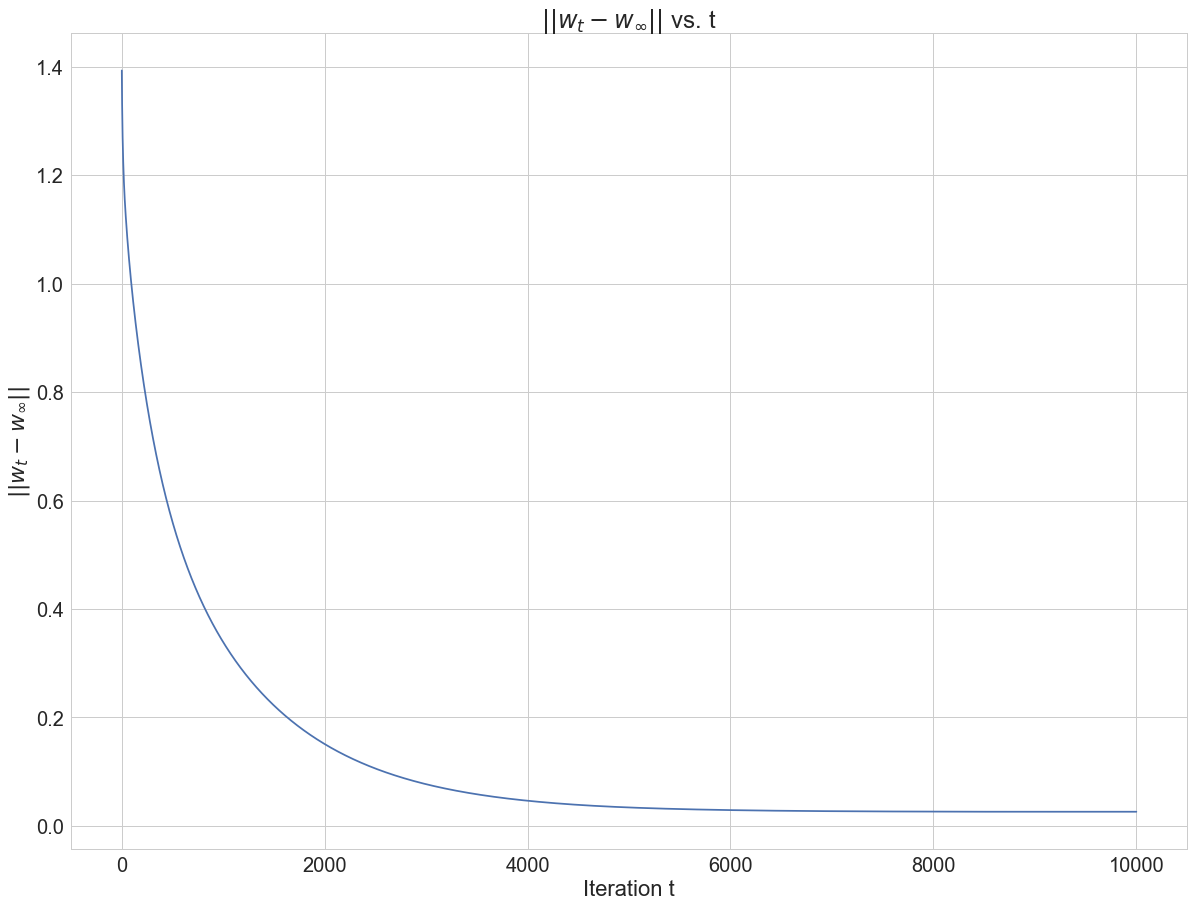

In [21]:
test_part_1()
    

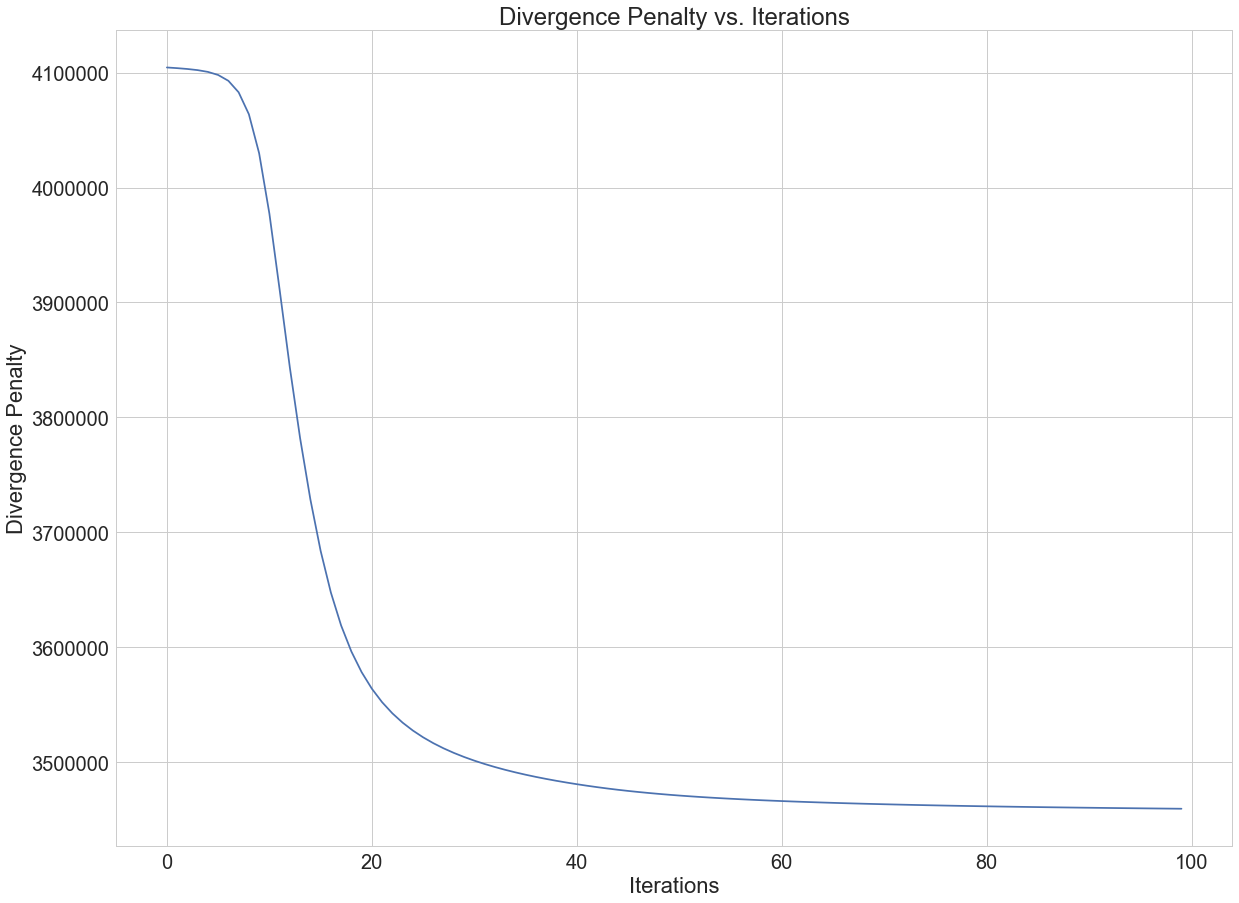

---------------------------------------------------------------------------------------------------------------------------------
    school - 0.042894    |    thing - 0.013012     |  government - 0.014396  |    travel - 0.018479    |     team - 0.035914     
   student - 0.034539    |     tell - 0.010662     |   american - 0.014320   |     site - 0.014794     |    player - 0.025812    
    child - 0.022952     |     ask - 0.010595      |    states - 0.014030    |   service - 0.014623    |    season - 0.020829    
    class - 0.014248     |     feel - 0.010546     |   country - 0.013159    | information - 0.013080  |     game - 0.020249     
  education - 0.012558   |     lot - 0.008353      |   military - 0.012160   |   computer - 0.012329   |     play - 0.019738     
   program - 0.012380    |    little - 0.007767    |     war - 0.011632      |     trip - 0.011488     |    coach - 0.016656     
   college - 0.012284    |     sit - 0.007428      |   official - 0.010505   |    flight -

In [10]:
test_part_2()

In [4]:
scores = np.genfromtxt('CFB2017_scores.csv', delimiter=',')
with open('TeamNames.txt', 'r') as f:
    team_names = f.read().split('\n')
team_names = team_names[:-1]
num_of_teams = len(team_names)
M = create_transition_matrix(scores, num_of_teams)

In [5]:
M.shape

(763, 763)

In [7]:
len(team_names)

763

In [9]:
np.sum(M)

763.0000000000001